#PSG-Audio_load_dataset.ipynb
This is the loader for the open access PSG-Audio Polysomnography (it was originally PSG-Audio_load_dataset_10_90_split.ipynb in our internal repo).

No data is stored in this repository. If you use the dataset please follow the original author's citation requests.

Paper: https://www.nature.com/articles/s41597-021-00977-w

Download: https://www.scidb.cn/en/detail?dataSetId=778740145531650048

This dataset is very large, for that reason the download is bit more complex and the high sample rate audio channels are not included.

The associated Jupyter notebook PSG-Audio_download_dataset.ipynb downloads and processes the files associated with a single subject into a pickled IR1 Pandas dataframe for each recorded overnight session.

The psg_audio_12ch_50sub_ir1_ptX.zip files contain the pickled dataframes for the first 50 subjects and is the input for this notebook.   

If you want to load additional subjects, change the sample frequency, or include other channels (body position, pulse rate, or the two audio) the dataframes must be downloaded and processed again (this takes about 25 minutes per subject).  

Altering the window size or step, selecting a subset of the channels, or changing subject allocation between train/valid/test can be done using stored pickled dataframes and this notebook.

This is work in progress and frequently updated, please check the repository at our [IMICS Lab Github repository](https://github.com/imics-lab/load_data_time_series) for the latest.

The basic load_data flow is modified a bit for this large dataset.
* Download and process the .rml and .edf datafiles associated with each subject in batches using PSA-Audio_download_dataset.ipynb.  This is performed by PSG-Audio_download_dataset.ipynb.  The download takes long time, approximately 25 minutes per subject.
* Unzip and read the pickled IR1 dataframes by subject
* Convert into IR2 - a set of two numpy arrays containing sliding window samples
   * X = (samples, time steps per sample, channels)  
   * y =  (samples, labels) # activity classification
   * sub = (samples, subject_number)
* Further process the IR2 arrays as needed - this is train/test aware, e.g. the training set may be better balanced by drop some majority class labels whereas the IR2s from subjects in the test set will not be.
* Concatenate the individual IR2 arrays into train/valid/test IR3 arrays 

Unlike some of the more simple loaders which can run as stand-alone .py files this notebook is currently setup to be run interactively with the resulting numpy arrays saved at the end.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* Many of the transforms here were developed while building versions for the other datasets; they need to be moved into a common set of functions for all.
* The balancing train and valid needs to be further refined.   Right now the abnormal vs not abnormal (apena and hypopnea) roughly match but that means the two abnormal and cardiac classes are still very unbalanced.


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import time
#import csv # probably not needed once download processes zip
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import savetxt
#from tabulate import tabulate # for verbose tables, showing data
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date, timedelta
import urllib.request # to get files from web w/o !wget

# Load shared transform (xform) functions and utils

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

In [3]:
try:
    import load_data_transforms as xform
except:
    get_py_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
    import load_data_transforms as xform

try:
    import load_data_utils as utils  
except:
    get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
    import load_data_utils as utils

# Setup environment and dataset parameters

In [4]:
# environment and execution parameters
my_dir = '.' # replace with absolute path if desired
ir1_dir = 'psg_ir1' # this is where the raw data IR1s will be stored
working_dir = 'psg_temp'
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
interactive = True # for exploring data and functions interactively
verbose = True

# dataset parameters
all_channel_list = [] # this will get populated from the IR1 dataframe column names
xform.time_steps = 500 # IR1 dataframes are set to 100Hz
xform.stride = 500 # how far to move for next window, if = times_step no overlap
# The label_map_<dataset> contains a mapping from strings to ints for all
# possible labels in the entire dataset.   This allows for predictable conversion
# regardless of the slices.
label_map_psg = dict(
    Cardiac = {'Normal':0,'Bradycardia':1,'Tachycardia':2,'LongRR':3,'PttDrop':4,'HeartrateDrop':5,'HeartRateRise':6,'Asystole':7,'SinusTachycardia':8,'NarrowComplexTachycardia':9,'WideComplexTachycardia':10,'AtrialFibrilation':11},
    Limb = {'Normal':0,'LegMovement':1,'AlternatingLegMuscleActivation':2,'HypnagogicFootTremor':3,'ExcessiveFreagmentaryMyoclonus':4,'RythmicMovementDisorder':5},
    Nasal = {'Normal':0, 'Snore':1 },
    Neuro = {'Normal':0,'Arousal':1},
    Respiratory = {'Normal':0,'ObstructiveApnea':1,'CentralApnea':2,'MixedApnea':3,'Hypopnea':4,'CheyneStokesRespiration':5,'PeriodicRespiration':6,'Respiratoryeffort-relatedarousal(RERA)':7},
    SpO2 = {'Normal':0,'RelativeDesaturation':1,'AbsoluteDesaturation':2})

# setup a global readme so various methods can append info as needed
readme = 'This readme auto-generated by PSG-Audio_load_dataset.ipynb\n'
readme += 'Executed on '
today = date.today()
readme += today.strftime("%B %d, %Y") + "\n"
readme += 'ref: https://github.com/imics-lab/load_data_time_series \n'

# Get IR1 dataframes
These dataframes contain the raw signal, label, and subject data.  They output by PSG-Audio_download_dataset.ipynb

In [5]:
# These are link shared on google drive, once stable should be moved to zenodo
#psg_ir1_zip_dict = {'PSG_18ch_IR1_1_of_5.zip':'1j3cUvsQArIIUu0OZIvIVcP_FtqKhTavv',
                    # 'PSG_18ch_IR1_2_of_5.zip':'19H-Yj2Bvs764zYeJ_ZUJ7U-djNMA2Wb_',
                    # 'PSG_18ch_IR1_3_of_5.zip':'1JM4k7nuMfvh5WwBS8AE2gQEjbOy7lsqb',
                    # 'PSG_18ch_IR1_4_of_5.zip':'1f1Pw5Wi2JAgwE0-DcTNEPTzoZCOB7Hwi',
                    # 'PSG_18ch_IR1_5_of_5.zip':'1Qy1FtwcXtX5-aNBxtOopTCXRgIc-vY_j'}
# I don't know why iterating over the dict doesn't work, gets access error for file                   
# for fname,url_code in psg_ir1_zip_dict.items():
#     full_code = url_code + '&confirm=t'
#     !gdown $full_code
#     utils.unzip_into_dir(fname,'PSG_IR1')

!gdown "1j3cUvsQArIIUu0OZIvIVcP_FtqKhTavv&confirm=t" # PSG-Audio zipped IR1 1 of 5
utils.unzip_into_dir('PSG_18ch_IR1_1_of_5.zip',ir1_dir)
# !gdown "19H-Yj2Bvs764zYeJ_ZUJ7U-djNMA2Wb_&confirm=t" # PSG-Audio zipped IR1 2 of 5
# utils.unzip_into_dir('PSG_18ch_IR1_2_of_5.zip',ir1_dir)
# !gdown "1JM4k7nuMfvh5WwBS8AE2gQEjbOy7lsqb&confirm=t" # PSG-Audio zipped IR1 3 of 5
# utils.unzip_into_dir('PSG_18ch_IR1_3_of_5.zip',ir1_dir)
# !gdown "1f1Pw5Wi2JAgwE0-DcTNEPTzoZCOB7Hwi&confirm=t" # PSG-Audio zipped IR1 4 of 5
# utils.unzip_into_dir('PSG_18ch_IR1_4_of_5.zip',ir1_dir)
# !gdown "1Qy1FtwcXtX5-aNBxtOopTCXRgIc-vY_j&confirm=t" # PSG-Audio zipped IR1 5 of 5
# utils.unzip_into_dir('PSG_18ch_IR1_5_of_5.zip',ir1_dir)

Downloading...
From: https://drive.google.com/uc?id=1j3cUvsQArIIUu0OZIvIVcP_FtqKhTavv&confirm=t
To: /content/PSG_18ch_IR1_1_of_5.zip
100% 2.13G/2.13G [00:12<00:00, 177MB/s]


# Build a list of subject numbers from filenames in directory 
Also run a quick sanity check the count - there are 192 subs total

In [6]:
import glob
count = 0
all_sub_list = []
for file in glob.glob(ir1_dir+r'/*.zip'):  # the r is a string escape
    count += 1
    # this next goofy mess extracts the sub number
    all_sub_list.append(file.split('/')[-1].split('_')[0])
all_sub_list = [int(i) for i in all_sub_list] # convert str to int
all_sub_list.sort() # this is an in-place operation, the list is modified

print('File count:', count)
print('Length of all_sub_list:',len(all_sub_list))
if (count != 192):
    print("WARNING: file count is", count, "but should be 192!")
if (len(all_sub_list) != 192):
    print("WARNING: all_sub_list length is", len(all_sub_list), "but should be 192!")

File count: 41
Length of all_sub_list: 41


# Sanity check a dataframe

get_df_from_pkl_zip reading psg_ir1/1000_ir1_df.pkl.zip
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1490000 entries, 2019-04-19 22:42:07 to 2019-04-20 02:50:26.990000
Data columns (total 25 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   EEG A1-A2      1490000 non-null  float32 
 1   EEG C3-A2      1490000 non-null  float32 
 2   EEG C4-A1      1490000 non-null  float32 
 3   EOG LOC-A2     1490000 non-null  float32 
 4   EOG ROC-A2     1490000 non-null  float32 
 5   EMG Chin       1490000 non-null  float32 
 6   Leg 1          1490000 non-null  float32 
 7   Leg 2          1490000 non-null  float32 
 8   ECG I          1490000 non-null  float32 
 9   Flow Patient1  1490000 non-null  float32 
 10  Flow Patient2  1490000 non-null  float32 
 11  Effort THO     1490000 non-null  float32 
 12  Effort ABD     1490000 non-null  float32 
 13  Snore0         1490000 non-null  float32 
 14  Snore1         1490000 non-null  f

None

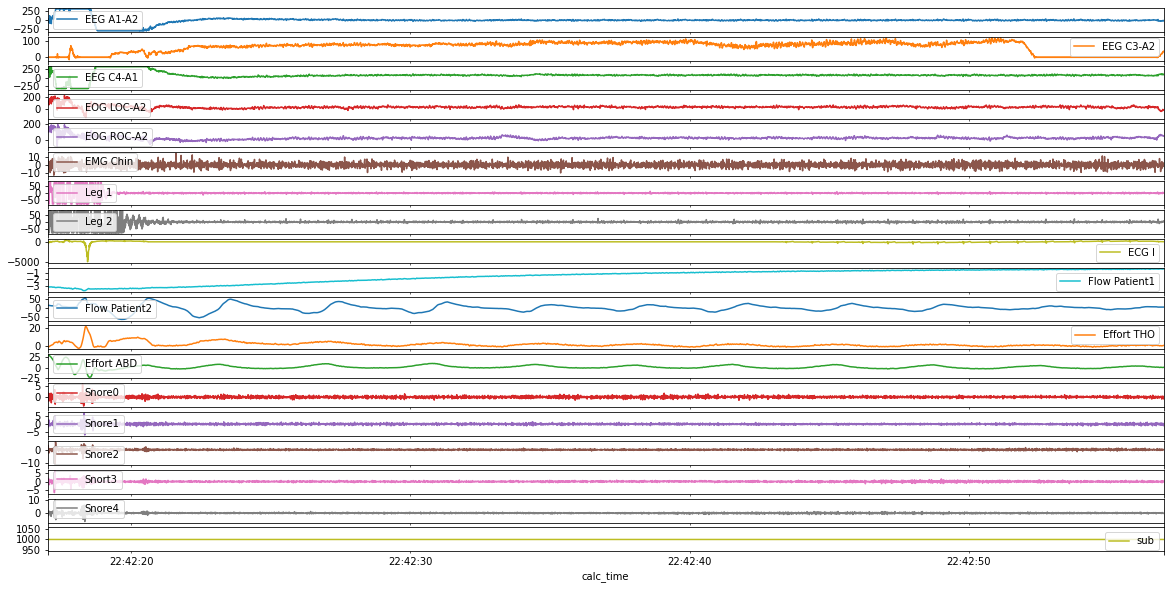

In [7]:
def get_df_from_pkl_zip(sub_num):
    """loads a dataframe in memory from <ir1_dir><sub_num>'_ir1_df.pkl.zip'"""
    pkl_ffname = os.path.join(ir1_dir,str(sub_num)+'_ir1_df.pkl.zip')
    if verbose:
        print('get_df_from_pkl_zip reading', pkl_ffname)
    df = pd.read_pickle(pkl_ffname)
    return df
if interactive:
    sub_num = 1000 # random pick from first zip file
    ir1_df = get_df_from_pkl_zip(sub_num = sub_num)
    display(ir1_df.info())
    # print("Dataframe shape is",ir1_df.shape)
    # display(ir1_df.head())
    # display(ir1_df.tail())
    y1 = 1000 # starting y value (row #)
    y2 = 5000 # ending, plotting the whole dataframe is too much.
    #ir1_df.iloc[499:999].plot(y='EEG A1-A2',subplots=True, layout=(1,2))
    ir1_df.iloc[y1:y2].plot(subplots=True, figsize=(20, 10)) # yay Pandas

# Quick test of new transform method - supports multi-label

assign_ints_ir1_labels() converting categorical strings to ints
df[Cardiac] value counts before
Normal         1250500
PttDrop         169200
LongRR           64200
Tachycardia       6100
Name: Cardiac, dtype: int64
df[Cardiac] value counts after
0    1250500
4     169200
3      64200
2       6100
Name: Cardiac, dtype: int64
assign_ints_ir1_labels() converting categorical strings to ints
df[Limb] value counts before
Normal         1441300
LegMovement      48700
Name: Limb, dtype: int64
df[Limb] value counts after
0    1441300
1      48700
Name: Limb, dtype: int64
assign_ints_ir1_labels() converting categorical strings to ints
df[Nasal] value counts before
Normal    1489300
Snore         700
Name: Nasal, dtype: int64
df[Nasal] value counts after
0    1489300
1        700
Name: Nasal, dtype: int64
assign_ints_ir1_labels() converting categorical strings to ints
df[Neuro] value counts before
Normal     1395800
Arousal      94200
Name: Neuro, dtype: int64
df[Neuro] value counts after
0    1

array([<Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>, <Axes: xlabel='calc_time'>,
       <Axes: xlabel='calc_time'>], dtype=object)

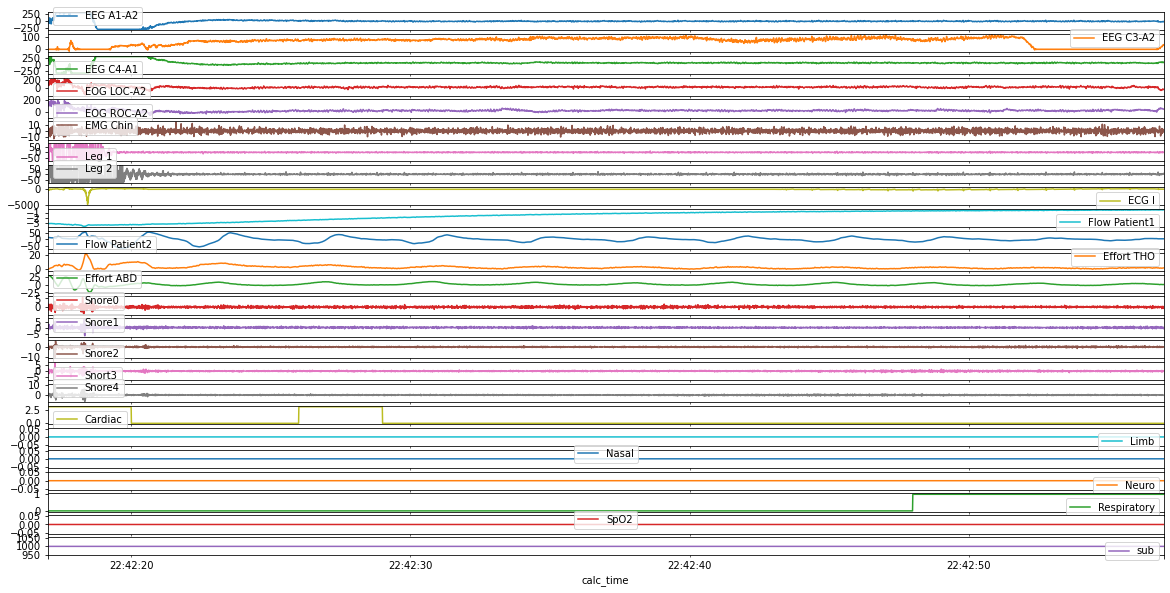

In [8]:
xform.verbose = True # turn on to see value counts
ir1_df = xform.assign_ints_ir1_labels(ir1_df, label_mapping_dict = label_map_psg)
xform.verbose = False # turn back off!
# Now converted from categorical string to ints the labels will plot as well
ir1_df.iloc[y1:y2].plot(subplots=True, figsize=(20, 10)) # yay Pandas


# Additional IR1 processing
This should be column based since rows will be transformed during conversion to IR2

In [9]:
# this was originally in PSG-Audio - simple but minimally tested because I'm
# afraid there will be too many other dependencies that need to change.
def drop_ir1_columns(df, drop_col_list):
    """Used to remove IR1 columns, typically channels or labels that are not
    required.   Benefit is that IR1 dataframes have named columns and by doing
    this early it will save time and memory later.  IMPORTANT: when dropping
    columns some of the meta-data may need to be modified as well, e.g.: the
    label_map_dict entries need to be dropped too.  There is a similar transform
    for IR2/IR3 numpy arrays.
    Args:
        df = an IR1 format dataframe
        drop_column_list = list of columns to drop ex ['accel_x','accel_y']
    Returns:
        df = updated IR1 sans columns"""
    # TODO:  a lot of error checking should be added here
    temp_all_cols = list(df)
    keep_ch_list = [x for x in temp_all_cols if x not in drop_col_list]
    if verbose:
        print('drop_ir1_columns')
        print('All',len(temp_all_cols),'IR1 columns:', temp_all_cols)
        print('Dropping',len(drop_col_list),'columns:', drop_col_list)
        print('Remaining',len(keep_ch_list),'columns:', keep_ch_list)
    df = df[keep_ch_list]
    return df
if interactive:
    ir1_df = drop_ir1_columns(ir1_df, drop_col_list = ['Limb','Nasal','Neuro','SpO2'])
    ir1_df.info()

drop_ir1_columns
All 25 IR1 columns: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient1', 'Flow Patient2', 'Effort THO', 'Effort ABD', 'Snore0', 'Snore1', 'Snore2', 'Snort3', 'Snore4', 'Cardiac', 'Limb', 'Nasal', 'Neuro', 'Respiratory', 'SpO2', 'sub']
Dropping 4 columns: ['Limb', 'Nasal', 'Neuro', 'SpO2']
Remaining 21 columns: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient1', 'Flow Patient2', 'Effort THO', 'Effort ABD', 'Snore0', 'Snore1', 'Snore2', 'Snort3', 'Snore4', 'Cardiac', 'Respiratory', 'sub']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500000 entries, 2019-05-28 23:00:24 to 2019-05-29 03:10:23.990000
Data columns (total 21 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   EEG A1-A2      1500000 non-null  float32
 1   EEG C3-A2      1500000 non-null  float32
 2   EEG C4

In [14]:
# this needs to move to transforms
def ir1_labels_to_binary(df, col_label_list):
    """Converts the label columns from 0,1,2,3,etc to 0 (assumed to be normal),
    and 1 (all non-zero entries will be converted to this).  Original usage was
    the PSG-Audio dataset which has multiple labels for abnormal respiratory
    and cardiac events.  Note a PSG-Audio single subject dataframe may not have
    multiple event types and in some cases/catergories are all 'normal'
    args:
        df: an IR1 dataframe (rows = timesteps, cols = channels and labels)
        col_label_list: a list of the column names to be converted.
    returns: an updated IR1 dataframe"""
    if verbose:
        print('ir1_labels_to_binary converting', col_label_list)
    for col_label in col_label_list:
        if verbose:
            print(col_label,"event type counts before\n"+str(df[col_label].value_counts(dropna=False)))
        df.loc[df[col_label] > 0, [col_label]] = 1
        if verbose:
            print(col_label,"event type counts after\n"+str(df[col_label].value_counts(dropna=False)))
    return df
if interactive:
    my_df = ir1_labels_to_binary(df = ir1_df, col_label_list = ['Cardiac','Respiratory'])
    #can run this plot before and after to sanity check, indices vary by sub
    #ir1_df['Respiratory'].iloc[300000:400000].plot(figsize=(20, 10))

ir1_labels_to_binary converting ['Cardiac', 'Respiratory']
Cardiac event type counts before
0    782800
1    717200
Name: Cardiac, dtype: int64
Cardiac event type counts after
0    782800
1    717200
Name: Cardiac, dtype: int64
Respiratory event type counts before
0    1078000
1     368900
4      53100
Name: Respiratory, dtype: int64
Respiratory event type counts after
0    1078000
1     422000
Name: Respiratory, dtype: int64


# Allocate subjects round-robin: 3 to train, 1 to valid, 1 to test
with a bit of clean-up for the left over 2.

In [9]:
# three to test, one to valid, test, repeat.
# TODO: Fix this wonky way of making mod 5...
temp_sub_list = all_sub_list.copy()
temp1 = temp_sub_list.pop() # take off the subs to make divisable by 5
all_subs_np = np.array(temp_sub_list)
temp_subs = all_subs_np.reshape(-1,5) # make 2D with 5 colums for 3,1,1 allocate
print(temp_subs)
train_subs = temp_subs[:,:3].reshape(-1) # first 3 columns then flatten
valid_subs = temp_subs[:,3].reshape(-1) # numpy is trippy sometime, just col 3
test_subs = temp_subs[:,4].reshape(-1)
train_subs = train_subs[train_subs != 999] # this dataframe has two flowpatient col labels?
train_subs = np.append(train_subs,temp1)
subs_split_dict = dict(train_subj = train_subs.tolist(),
                valid_subj = valid_subs.tolist(),
                test_subj = test_subs.tolist())
print(subs_split_dict)
print("# train subs =", len(subs_split_dict['train_subj']))
print("# valid subs =", len(subs_split_dict['valid_subj']))
print("# test subs =", len(subs_split_dict['test_subj']))


[[ 995  999 1000 1006 1008]
 [1010 1014 1016 1018 1020]
 [1022 1024 1026 1028 1037]
 [1039 1041 1043 1045 1057]
 [1059 1069 1071 1073 1082]
 [1084 1086 1088 1089 1093]
 [1095 1104 1106 1110 1120]
 [1122 1129 1131 1135 1137]]
{'train_subj': [995, 1000, 1010, 1014, 1016, 1022, 1024, 1026, 1039, 1041, 1043, 1059, 1069, 1071, 1084, 1086, 1088, 1095, 1104, 1106, 1122, 1129, 1131, 1157], 'valid_subj': [1006, 1018, 1028, 1045, 1073, 1089, 1110, 1135], 'test_subj': [1008, 1020, 1037, 1057, 1082, 1093, 1120, 1137]}
# train subs = 24
# valid subs = 8
# test subs = 8


In [14]:
cross_val_cfg = True # setup for group based cross-validation - combine train and valid subs
if (cross_val_cfg):
    train_valid_subs = subs_split_dict['train_subj'] + subs_split_dict['valid_subj']
    train_valid_subs.sort()
    print(len(train_valid_subs))
    print(train_valid_subs)
    subs_split_dict['train_subj'] = train_valid_subs
    subs_split_dict['valid_subj'] = []
    print("# train subs =", len(subs_split_dict['train_subj']))
    print("# valid subs =", len(subs_split_dict['valid_subj']))
    print("# test subs =", len(subs_split_dict['test_subj']))

32
[995, 1000, 1006, 1010, 1014, 1016, 1018, 1022, 1024, 1026, 1028, 1039, 1041, 1043, 1045, 1059, 1069, 1071, 1073, 1084, 1086, 1088, 1089, 1095, 1104, 1106, 1110, 1122, 1129, 1131, 1135, 1157]
# train subs = 32
# valid subs = 0
# test subs = 8


In [15]:
# this cell copied from transforms, updated for y of higher dims
def get_ir2_from_ir1(df, all_label_list = ['label'], sub_label = 'sub'):
    """slice the IR1 dataframe into sliding window segments of
    time_steps length and return X, y, sub, ss_times ndarrays.
    If stride = time_steps there is no overlap of the sliding window.
    This version does not use append, better for RAM.  It also does not
    collapse the labels or sub arrays since that varies between train/test.
    args:
        df: pandas datetime indexed dataframe columns - channel(s), label, sub
        all_label_list = list of the label names e.g. ['label'] for single label
           Hint:  can pass keys of dict using = list(label_map_<dataset>)
        sub_label = string, only needed if sub column is not 'sub'
    Global params used
        time_steps: number of samples in window, will discard a partial final window
        stride:  how far to move window, no overlap if equal to time_steps.
    Returns:
        X : ndarray of float32 shape(instances,timesteps,channels))
        y : ndarray of int8 integer encoded labels of shape (instances, labels)
        sub : ndarray of int16 subject numbers shape (instances,1)
        ss_times : ndarray of datetime64 containing the start and stop time of 
            each window for label cleaning shape (instances, 2)
        channel_list : df column names minus label_list and 'sub'
    """    
    # TODO:  Should confirm datetimes are contiguous and warn if not.
    # the channel list is in dataframe but not in the numpy arrays so return
    # in case needed later.
    channel_list = [x for x in list(df.columns) if x not in all_label_list]
    channel_list.remove(sub_label) # ditto - should probably add a check
    if verbose:
        print('Channels in X:',channel_list)
    X = df[channel_list].to_numpy(dtype = 'float32')
    y = df[all_label_list].to_numpy(dtype = 'int8') # doesn't work for strings
    sub = df[sub_label].to_numpy(dtype = 'int16') # for datasets with sub #s > 255
    if verbose:
        print('X,y,sub array shapes before sliding window', X.shape, y.shape, sub.shape)
    #https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
    shapex = (xform.time_steps,X.shape[1]) # samples (rows to include) and n-dim of original (all channels)
    shapey = (xform.time_steps,y.shape[1]) # samples (rows to include) and n-dim of y (might fail on single shape)
    shapesub = (xform.time_steps,) # samples (rows to include) and only one column
    X = np.lib.stride_tricks.sliding_window_view(X, shapex)[::xform.stride, :]
    X = X[:,0,:,:] # I admit I don't understand why this dimension appears...
    y = np.lib.stride_tricks.sliding_window_view(y, shapey)[::xform.stride, :]
    y = y[:,0,:,:] # I admit I don't understand why this dimension appears...
    sub = np.lib.stride_tricks.sliding_window_view(sub, shapesub)[::xform.stride, :]
    # Build a numpy array of the start and stop timestamps for each sliding
    # window - the IR1 indices.  This is to help label cleaning if needed.
    timestamps_np = df.index.to_numpy(dtype = 'datetime64')
    shape_ts = (xform.time_steps,) # samples (rows to include) and only one column
    timestamps_np = np.lib.stride_tricks.sliding_window_view(timestamps_np, shape_ts)[::xform.stride, :]
    start_times = timestamps_np[:,0]
    stop_times = timestamps_np[:,-1]
    ss_times = np.column_stack((start_times,stop_times))
    if verbose:
        print('X,y,sub,ss_times array shapes after sliding window', X.shape, y.shape, sub.shape, ss_times.shape)
    return X, y, sub, ss_times, channel_list
if interactive:
    my_X, my_y, my_sub, my_ss_times, x_channel_list = get_ir2_from_ir1(ir1_df,all_label_list = list(label_map_psg))
    print(utils.tabulate_numpy_arrays({'my_X':my_X,'my_y':my_y,'my_sub':my_sub,'my_ss_times':my_ss_times}))
    print("Returned x_channel_list", all_channel_list)

Channels in X: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient1', 'Flow Patient2', 'Effort THO', 'Effort ABD', 'Snore0', 'Snore1', 'Snore2', 'Snort3', 'Snore4']
X,y,sub array shapes before sliding window (1490000, 18) (1490000, 6) (1490000,)
X,y,sub,ss_times array shapes after sliding window (2980, 500, 18) (2980, 500, 6) (2980, 500) (2980, 2)
array        shape            data type
-----------  ---------------  --------------
my_X         (2980, 500, 18)  float32
my_y         (2980, 500, 6)   int8
my_sub       (2980, 500)      int16
my_ss_times  (2980, 2)        datetime64[ns]
Returned x_channel_list []


In [17]:
print("Labels and counts before drop (counts are divided by time-steps)")
unique, counts = np.unique(my_y[:,:,4], return_counts=True)
print (np.asarray((unique, counts/xform.time_steps)).T)

Labels and counts before drop (counts are divided by time-steps)
[[0.000e+00 2.156e+03]
 [1.000e+00 7.378e+02]
 [4.000e+00 1.062e+02]]


In [16]:
from scipy import stats as st # for assigning labels as mode of sliding window

In [25]:
temp_y, counts = st.mode(my_y, axis = 1, keepdims = True)
print(temp_y.shape)
unique, counts = np.unique(temp_y[:,:,:], return_counts=True)
print (np.asarray((unique, counts)).T)
temp_y = temp_y[:,0,:]
print(temp_y.shape)
unique, counts = np.unique(temp_y[:,:], return_counts=True)
print (np.asarray((unique, counts)).T)

(3000, 1, 6)
[[    0 13592]
 [    1  3553]
 [    2    30]
 [    3   363]
 [    4   462]]
(3000, 6)
[[    0 13592]
 [    1  3553]
 [    2    30]
 [    3   363]
 [    4   462]]


In [20]:
print(temp_y.shape)

(3000, 6)


In [28]:
resp_y = temp_y[:,0:1]
print(resp_y.shape)
normal_idx = resp_y.any(axis=1)
unique, counts = np.unique(normal_idx, return_counts=True)
print (np.asarray((unique, counts)).T)

(3000, 1)
[[   0 1571]
 [   1 1429]]


In [15]:
# These calls didn't seem to matter (no NaN) or work (unify)
# xform.verbose = True
# my_X, my_y, my_sub, my_ss_times = xform.drop_ir2_nan(my_X, my_y, my_sub, my_ss_times)
# unique, counts = np.unique(my_y, return_counts=True)
# print (np.asarray((unique, counts/xform.time_steps)).T)
# my_X, my_y, my_sub, my_ss_times = xform.unify_ir2_labels(my_X, my_y, my_sub, my_ss_times, method = 'mode') 
# print("Labels and counts after mode")
# unique, counts = np.unique(my_y, return_counts=True)
# print (np.asarray((unique, counts)).T)

0 NaN entries found, removing
[[0.0000e+00 3.7216e+03]
 [1.0000e+00 1.4156e+03]
 [2.0000e+00 3.6600e+01]
 [3.0000e+00 3.4040e+02]
 [4.0000e+00 4.8580e+02]]
Labels and counts after drop
[[   0 3718]
 [   1 1427]
 [   2   30]
 [   3  363]
 [   4  462]]


In [20]:
# new for PSG-Audio, also needs to move to xforms.
def one_hot_multi_label_y(y, label_map_dict):
    """Takes an integer encoded multi-label (multi-column) y numpy array and
    splits it into multiple one-hot encoded arrays.
    Args:
        y = numpy int array, shape (samples, #labels)
        label_map_dict = dict with entry for each of the labels, used for shape calcs
    Returns:
        dict containing key = y_oh<label_map_name> and item = one-hot int array"""
    if verbose:
        print("running one_hot_multi_label_y xform")
        print("original input - integer encoded:\n",y)
    num_labels = (len(label_map_dict))
    if num_labels != y.shape[1]:
        print("ERROR: num_labels in label map dict", num_labels, "doesn't match number y columns", y.shape[1])
        return y
    y_oh_dict = {} # empty dict to add in one-hot encoded versions of y
    for lname, label_map in label_map_dict.items():
        num_class = len(label_map) # the number of classes for this label
        col_num = int(list(label_map_dict).index(lname))
        new_y_oh = tf.keras.utils.to_categorical(y[:,col_num], num_classes=num_class)
        new_y_oh = tf.constant(new_y_oh, dtype = np.int8)#, shape=[test_y.shape[0],num_class])
        y_oh_dict[lname] = new_y_oh
    return y_oh_dict
if interactive:
    label_map_test = dict(
    first = {'Normal':0,'first_1':1,'first_2':2,'first_3':3 },
    second = {'Normal':0,'second_1':1,'second_2':2,})
    test_y = np.array([[1, 2], [0, 1],[1, 0]], np.int8)
    new_y_oh = one_hot_multi_label_y(test_y, label_map_test)
    print("Output dictionary")
    print(new_y_oh)

running one_hot_multi_label_y xform
original input - integer encoded:
 [[1 2]
 [0 1]
 [1 0]]
Output dictionary
{'first': <tf.Tensor: shape=(3, 4), dtype=int8, numpy=
array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]], dtype=int8)>, 'second': <tf.Tensor: shape=(3, 3), dtype=int8, numpy=
array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int8)>}


In [21]:
def get_psg_dicts(X, y):
    """Converts 18 channel X input of PSG-Audio data into dictionary based
    on signal modality.   Same for y based on label.
    Args:
        X = IR2 or IR3 dataframe with PSG-Audio channel data
        y = IR2 or IR3 dataframe with PSG-Audio label data, int encoded.
        returns dictionary of X arrays and one-hot y arrays"""
    eeg = X[:,:,0:3] # ch (0,1,2)
    eog = X[:,:,3:5] # ch (3,4)
    emg = X[:,:,5:6] # ch (5), this syntax keeps the shape
    leg = X[:,:,6:8] # ch (6,7)
    ecg = X[:,:,8:9] # ch (8)
    flow = X[:,:,9:11] # ch (9,10) nasal cannula
    reff = X[:,:,11:13] # ch (11,12) abd thor respiratory effort RIP bands
    snore = X[:,:,13:18] # ch (13,14,15,16,17) five snore channels (due to 500Hz)

    x_dict = {'eeg': eeg, 'eog':eog,'emg': emg, 'leg':leg,'ecg':ecg,
              'flow':flow,'reff':reff,'snore': snore}
    y_dict = one_hot_multi_label_y(y, label_map_psg)
    return x_dict, y_dict
if interactive:
    sub_num = 1000 # random pick from first zip file
    ir1_df = get_df_from_pkl_zip(sub_num = sub_num)
    ir1_df = xform.assign_ints_ir1_labels(ir1_df, label_mapping_dict = label_map_psg)
    ir2_X, ir2_y, ir2_sub, ir2_ss_times, x_channel_list = get_ir2_from_ir1(ir1_df,all_label_list = list(label_map_psg))
    # TODO: the unify_ir2_labels in transforms needs to be updated for this
    ir2_y, counts = st.mode(ir2_y, axis = 1, keepdims = True)
    ir2_y = ir2_y[:,0,:]
    my_x_dict, my_y_dict = get_psg_dicts(ir2_X, ir2_y)
    for key, item in my_x_dict.items():
        print(utils.tabulate_numpy_arrays({key:item}))
    for key, item in my_y_dict.items():
        print(utils.tabulate_numpy_arrays({key:item}))


get_df_from_pkl_zip reading psg_ir1/1000_ir1_df.pkl.zip
Channels in X: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient1', 'Flow Patient2', 'Effort THO', 'Effort ABD', 'Snore0', 'Snore1', 'Snore2', 'Snort3', 'Snore4']
X,y,sub array shapes before sliding window (1490000, 18) (1490000, 6) (1490000,)
X,y,sub,ss_times array shapes after sliding window (2980, 500, 18) (2980, 500, 6) (2980, 500) (2980, 2)
running one_hot_multi_label_y xform
original input - integer encoded:
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [3 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [3 1 0 0 0 0]
 [0 0 0 0 0 0]]
array    shape           data type
-------  --------------  -----------
eeg      (2980, 500, 3)  float32
array    shape           data type
-------  --------------  -----------
eog      (2980, 500, 2)  float32
array    shape           data type
-------  --------------  -----------
emg      (2980, 500, 1)  float32
array    shape           data type
------- 

In [39]:
def psg_audio_load_dataset():
    # TODO:  these should be calculated from an example dataframe
    num_ch = 18 # the number of signal channels is the 3rd dim of X
    num_lbl = 6 # the number of labels, 2nd dim of y

    # TODO: This should be refactored - too much duplication
    # ----TRAIN----create blank ndarrays to append to
    ir3_X = np.zeros(shape=(1,xform.time_steps,num_ch), dtype = 'float32')
    ir3_y = np.zeros(shape=(1,num_lbl),dtype='int8') # only a few labels
    ir3_sub = np.zeros(shape=(1,1),dtype='int16') # PSG-Audio has > 255 sub #s
    ir3_ss_times = np.zeros(shape=(1,2),dtype='datetime64') # start/stop window times

    for sub_num in subs_split_dict['train_subj']:
        #if verbose:
        print('Processing Train', sub_num)
        ir1_df = get_df_from_pkl_zip(sub_num = sub_num)
        ir1_df = xform.assign_ints_ir1_labels(ir1_df, label_mapping_dict = label_map_psg)

        ir2_X, ir2_y, ir2_sub, ir2_ss_times, x_channel_list = get_ir2_from_ir1(ir1_df,all_label_list = list(label_map_psg))
        ir3_X = np.vstack([ir3_X, ir2_X])

        # TODO: the unify_ir2_labels in transforms needs to be updated for this
        ir2_y, counts = st.mode(ir2_y, axis = 1, keepdims = True)
        ir2_y = ir2_y[:,0,:]
        ir3_y = np.vstack([ir3_y, ir2_y])

        ir2_sub = ir2_sub[:,0] # repeat for sub array
        ir2_sub = ir2_sub[np.newaxis].T
        ir3_sub = np.vstack([ir3_sub, ir2_sub])

        ir3_ss_times = np.vstack([ir3_ss_times, ir2_ss_times])
    
    # files added, delete first row placeholders
    ir3_X = np.delete(ir3_X, (0), axis=0) 
    ir3_y = np.delete(ir3_y, (0), axis=0) 
    ir3_sub = np.delete(ir3_sub, (0), axis=0)
    ir3_ss_times = np.delete(ir3_ss_times, (0), axis=0)

    #split signals by modality
    x_train_dict, y_train_dict = get_psg_dicts(ir3_X, ir3_y)

    return x_train_dict, y_train_dict, ir3_sub

    # # ----VALID----create blank ndarrays to append to
    # This code needs to be checked for case with defined valid subs versus
    # config for returning the sub arrays for group cross validation.
    # ir3_X = np.zeros(shape=(1,xform.time_steps,num_ch), dtype = 'float32')
    # ir3_y = np.zeros(shape=(1,num_lbl),dtype='int8') # only a few labels
    # ir3_sub = np.zeros(shape=(1,1),dtype='int16') # PSG-Audio has > 255 sub #s
    # ir3_ss_times = np.zeros(shape=(1,2),dtype='datetime64') # start/stop window times

    # for sub_num in subs_split_dict['valid_subj']:
    #     #if verbose:
    #     print('Processing Valid', sub_num)
    #     ir1_df = get_df_from_pkl_zip(sub_num = sub_num)
    #     ir1_df = xform.assign_ints_ir1_labels(ir1_df, label_mapping_dict = label_map_psg)

    #     ir2_X, ir2_y, ir2_sub, ir2_ss_times, x_channel_list = get_ir2_from_ir1(ir1_df,all_label_list = list(label_map_psg))
    #     ir3_X = np.vstack([ir3_X, ir2_X])

    #     # TODO: the unify_ir2_labels in transforms needs to be updated for this
    #     ir2_y, counts = st.mode(ir2_y, axis = 1, keepdims = True)
    #     ir2_y = ir2_y[:,0,:]
    #     ir3_y = np.vstack([ir3_y, ir2_y])

    #     ir2_sub = ir2_sub[:,0] # repeat for sub array
    #     ir2_sub = ir2_sub[np.newaxis].T
    #     ir3_sub = np.vstack([ir3_sub, ir2_sub])

    #     ir3_ss_times = np.vstack([ir3_ss_times, ir2_ss_times])
    # x_valid_dict, y_valid_dict = get_psg_dicts(ir3_X, ir3_y)

    # return x_train_dict, y_train_dict, x_valid_dict, y_valid_dict

if interactive:
    verbose = False
    x_train_dict, y_train_dict, sub_train = psg_audio_load_dataset()
    for key, item in x_train_dict.items():
        print(utils.tabulate_numpy_arrays({key:item}))
    for key, item in y_train_dict.items():
        print(utils.tabulate_numpy_arrays({key:item}))
    print(utils.tabulate_numpy_arrays({'sub_train':sub_train}))

Processing Train 995
Processing Train 1000
Processing Train 1006
Processing Train 1010
Processing Train 1014
Processing Train 1016
Processing Train 1018
Processing Train 1022
Processing Train 1024
Processing Train 1026
Processing Train 1028
Processing Train 1039
Processing Train 1041
Processing Train 1043
Processing Train 1045
Processing Train 1059
Processing Train 1069
Processing Train 1071
Processing Train 1073
Processing Train 1084
Processing Train 1086
Processing Train 1088
Processing Train 1089
Processing Train 1095
Processing Train 1104
Processing Train 1106
Processing Train 1110
Processing Train 1122
Processing Train 1129
Processing Train 1131
Processing Train 1135
Processing Train 1157
array    shape            data type
-------  ---------------  -----------
eeg      (97680, 500, 3)  float32
array    shape            data type
-------  ---------------  -----------
eog      (97680, 500, 2)  float32
array    shape            data type
-------  ---------------  -----------
emg    

# Save arrays to file using pickle - these should be moved to utils file

In [25]:
import pickle

file = open('x_train_dict', 'wb')
pickle.dump(x_train_dict, file)
file.close()

file = open('y_train_dict', 'wb')
pickle.dump(y_train_dict, file)
file.close()

file = open('sub_train', 'wb')
pickle.dump(sub_train, file)
file.close()

In [28]:
# takes a really long time to download.  Try compressed version.
# First group of 40ish subjects X_train is 3.28GB uncompressed shrinks 
# to 1.03GB with this code but takes 8 minutes or so to compress.
# credit https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
# Pickle a file and then compress it into a file with extension 
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [45]:
compressed_pickle('x_train_dict', x_train_dict)
compressed_pickle('y_train_dict', y_train_dict)
compressed_pickle('sub_train', sub_train)

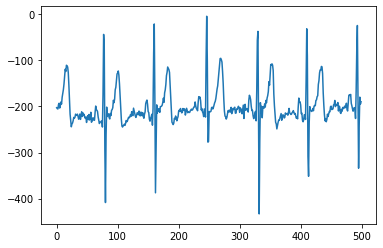

In [44]:
# grab a single sliding window to sanity check
test_window = x_train_dict['ecg'][1]
plt.plot(test_window)

# Older code - not part of latest update and check-in.

In [ ]:
interactive = False

In [ ]:
def get_ir3(er1_sub_list = unlabeled_subs_list,
            time_steps = 500,
            stride = 500 #if equal to time_steps there will be no overlap of sliding window
    ):
    """This is the main function to create the three ndarrays X, y, sub from
    the dataset zip file.  It is an updated version of get_xys.  
    2) Read and processes each subject's PSG IR1 dataframe into X (data),
     y (labels), and sub (subject number) IR2 ndarrays.
    3) Stackes the IR2 arrays into IR3 (X, y, sub) arrays
    """
    # create blank ndarrays to append to
    num_ch = 12 # the number of signal channels is the 3rd dim of X
    ir3_X = np.zeros(shape=(1,time_steps,num_ch), dtype = 'float32')
    ir3_y = np.zeros(shape=(1,1),dtype='int8') # only a few labels
    ir3_sub = np.zeros(shape=(1,1),dtype='int16') # PSG-Audio has > 255 sub #s
    print("er1_sub_list", er1_sub_list)
    for sub_num in er1_sub_list:
        #if verbose:
        #print('Processing ', sub_num)
        ir1_df = get_df_from_pkl(sub_num = sub_num)
        #print(ir1_df['sub'].head)
        ir1_df = ir1_labels_to_binary(df = ir1_df, col_label_list = ['Respiratory']) # all abnormal events = 1

        #if verbose:
        #    ir1_df['Cardiac'].value_counts()
        #    print ("Label Counts - # samples before sliding window\n",ir1_df['Cardiac'].value_counts())
        ir2_X, ir2_y, ir2_sub, channel_list = \
            get_ir2_from_ir1(ir1_df, 
                             all_label_list = ['Cardiac', 'Respiratory', 'SpO2', 'Neuro'],
                             keep_label = 'Respiratory', 
                             time_steps = 500, stride = 500)
        #print("First sub entry before vstack" ,ir2_sub[0])
        ir2_X, ir2_y, ir2_sub = clean_ir2(ir2_X, ir2_y, ir2_sub)
        #ir2_X, ir2_y, ir2_sub = drop_label_ir2_ir3(ir2_X, ir2_y, ir2_sub, 'Undefined')
        ir3_X = np.vstack([ir3_X, ir2_X])
        ir3_y = np.vstack([ir3_y, ir2_y])
        #print("First sub entry before vstack" ,ir2_sub[0])
        ir3_sub = np.vstack([ir3_sub, ir2_sub])
        #shutil.rmtree(working_dir)

    #delete first row placeholders
    X = np.delete(ir3_X, (0), axis=0) 
    y = np.delete(ir3_y, (0), axis=0) 
    sub = np.delete(ir3_sub, (0), axis=0)
    sub = sub.astype(np.uint16) # convert from float to int16, more than 255 subs

    xys_info = 'This needs work in PSG-Audio_load_dataset.ipynb\n'
    xys_info += '\nTime steps =' + str(time_steps) + ', Stride =' + str(stride) + ', no resample\n'
    xys_info += 'Final Shapes\n'
    xys_info += "X shape " + str(X.shape) + " dtype = " + str(X.dtype) + "\n"
    xys_info += "y shape " + str(y.shape) + " dtype = " + str(y.dtype) + "\n"
    xys_info += "sub shape " + str(sub.shape) + " dtype = " + str(sub.dtype) + "\n"
    xys_info += "Channel names:" + str(channel_list) + "\n"
    # Get final counts for label ndarray - not quite as easy as pandas df
    xys_info += "Final Label Counts\n"
    unique, counts = np.unique(y, return_counts=True)
    xys_info += str(np.asarray((unique, counts)).T)
    xys_info += "\nSamples per Subject\n"
    unique, counts = np.unique(sub, return_counts=True)
    xys_info += str(np.asarray((unique, counts)).T)
    return X, y, sub, xys_info
if interactive:
    X, y, sub, xys_info = get_ir3()
    print(tabulate_numpy_arrays({"X":X, "y":y, "sub":sub}))
    unique, counts = np.unique(y, return_counts=True)
    print('Label Counts:\n',str(np.asarray((unique, counts)).T))
    print("Sanity check on sub numbers",np.unique(sub))

In [ ]:
def old_psg_audio_load_dataset(
    verbose = False,
    use_saved_xysub = False, # get X,y,sub from zip, True = faster to used saved ones
    incl_val_group = False, # split train into train and validate
    split_subj = unlabeled_subs_split_dict,
    #keep_channel_list = ['accel_ttl'],
    one_hot_encode = True, # make y into multi-column one-hot, one for each activity
    return_info_dict = False, # return dict of meta info along with ndarrays
    suppress_warn = False # special case for stratified warning
    ):
    """Requires a zip file of sub IR1 dataframes from PSG-Audio_download.ipynb
    returns arrays by separating into _train, _validate, and _test arrays for
    X and y based on split_sub dictionary."""
    log_info = "Generated by PSG-Audio_load_dataset_10_90.ipynb\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    log_info += "sub dict = " + str(split_subj) + "\n"
    if (not use_saved_xysub):
        X, y, sub, xys_info = get_ir3()
    else:
        # read previously stored X, y, sub arrays instead of creating from zip
        # saves time when running multiple train/test split experiments
        # e.g. passing different subject dictionaries to this method
        # create & save X, y, sub using Leotta_2021_get_X_y_sub.ipynb interactively
        # this is not a big deal for TWristAR which is purposely small.
        input_dir = '/content/drive/MyDrive/Processed_Datasets/PSG_Audio'
        X = np.load(input_dir + '/'+'X.npy')
        y = np.load(input_dir + '/'+'y.npy')
        sub = np.load(input_dir + '/'+'sub.npy')
        log_info += "X, y, sub loaded from "+str(input_dir)+"\n"
    # Drop unwanted channels from X
    #log_info += "Keeping channels" + str(keep_channel_list) + "\n"
    #X = limit_channel_ir3(X, keep_channel_list = keep_channel_list)
    # write initial array info to log_info
    headers = ("Initial Array","shape", "object type", "data type")
    mydata = [("X", X.shape, type(X), X.dtype),
              ("y", y.shape, type(y), y.dtype),
              ("sub", sub.shape, type(sub), sub.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers) + "\n"
    
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
    # Need to look at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if (verbose):
            print("One-hot-encoding: category names -> int -> one-hot \n")
            print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        y=onehot_encoded.astype('uint8')
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['valid_subj']))
        x_train = X[train_index]
        y_train = y[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = X[train_index]
        y_train = y[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['valid_subj']))
        x_validation = X[validation_index]
        y_validation = y[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]

    headers = ("Returned Array","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype)]
    if (incl_val_group):
        mydata += [("x_validation:", x_validation.shape, type(x_validation), x_validation.dtype),
                        ("y_validation:", y_validation.shape ,type(y_validation), y_validation.dtype)]
    mydata += [("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers)
    if (incl_val_group):
        if (return_info_dict):
            return x_train, y_train, x_validation, y_validation, x_test, y_test, log_info
        else:
            return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        if (return_info_dict):
            return x_train, y_train, x_test, y_test, log_info
        else:
            return x_train, y_train, x_test, y_test


# Main is setup to be a demo and bit of unit test.

In [ ]:
verbose = False # otherwise a lot of output from main.

In [ ]:
if __name__ == "__main__":
    print("Get PSG-Audio (50 sub version)")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = psg_audio_load_dataset(incl_val_group = True,
                                                      return_info_dict = True)
    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_valid:", x_valid.shape, x_valid.dtype),
            ("y_valid:", y_valid.shape, y_valid.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print ('\n','-'*72) # just a dashed line

    print("\n----------- Contents of returned log_info ---------------")
    print(log_info)

Get PSG-Audio (50 sub version)
er1_sub_list [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449, 1453, 1459, 1463, 1476, 1480, 1488]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



 Array     shape              data type
--------  -----------------  -----------
x_train:  (243933, 500, 12)  float32
y_train:  (243933, 2)        uint8
x_valid:  (0, 500, 12)       float32
y_valid:  (0, 2)             uint8
x_test:   (0, 500, 12)       float32
y_test:   (0, 2)             uint8

 ------------------------------------------------------------------------

----------- Contents of returned log_info ---------------
Generated by PSG-Audio_load_dataset_10_90.ipynb
March 16, 2023
sub dict = {'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449,

# Special processing due to highly unbalanced nature of PSG_Audio
This drops approximately 2/3rds of the normal samples from the training set and half the normal samples from the validation set.   Should probably look at the splits first and make a more algorithmic decision.

Note this version is setup for 20s window which is extremely unbalanced - the mod values will need to be changed for any other window size.

This really needs to be put into a function or use existing libraries.  Good write-up here:
https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704


In [ ]:
y_train_bin = np.argmax(y_train, axis=-1) # undo one-hot encoding
y_valid_bin = np.argmax(y_valid, axis=-1) # undo one-hot encoding
balancing_info = "Rebalancing by dropping some 'normal' windows, see notes.\n"
balancing_info += "Train counts before:\n"
unique, counts = np.unique(y_train_bin, return_counts=True)
balancing_info += str(np.asarray((unique, counts)).T) + "\n"
balancing_info += "Valid counts before:\n"
unique, counts = np.unique(y_valid_bin, return_counts=True)
balancing_info += str(np.asarray((unique, counts)).T) + "\n"
# This drops any 'normal' window that has a value not evenly
# divisible by 3.  Not exactly 2 in 3 but close for very unbalanced
idx = []
for i in range(y_train_bin.shape[0]):
    if (y_train_bin[i] == 0) and (i%3 == 0):  # set mod based on imbalance
        idx.append(True)
    elif (y_train_bin[i] == 1):
        idx.append(True)
    else:
        idx.append(False)
y_train = y_train[idx]
x_train = x_train[idx]
# repeat for valid set since accuracy metric used for hyper-tuning
idx = []
for i in range(y_valid_bin.shape[0]):
    if (y_valid_bin[i] == 0) and (i%6 == 0):
        idx.append(True)
    elif (y_valid_bin[i] == 1):
        idx.append(True)
    else:
        idx.append(False)
y_valid = y_valid[idx]
x_valid = x_valid[idx]
unique, counts = np.unique(np.argmax(y_train, axis=-1), return_counts=True)
balancing_info += "Train counts after:\n"
balancing_info += str(np.asarray((unique, counts)).T) +"\n"
unique, counts = np.unique(np.argmax(y_valid, axis=-1), return_counts=True)
balancing_info += "Valid counts after:\n"
balancing_info += str(np.asarray((unique, counts)).T) +"\n"
print(balancing_info)

headers = ("Array","shape", "data type")
mydata = [("x_train:", x_train.shape, x_train.dtype),
        ("y_train:", y_train.shape, y_train.dtype),
        ("x_valid:", x_valid.shape, x_valid.dtype),
        ("y_valid:", y_valid.shape, y_valid.dtype),
        ("x_test:", x_test.shape, x_test.dtype),
        ("y_test:", y_test.shape, y_test.dtype)]
print("\n",tabulate(mydata, headers=headers))

Rebalancing by dropping some 'normal' windows, see notes.
Train counts before:
[[     0 182208]
 [     1  61725]]
Valid counts before:
[]
Train counts after:
[[    0 60628]
 [    1 61725]]
Valid counts after:
[]


 Array     shape              data type
--------  -----------------  -----------
x_train:  (122353, 500, 12)  float32
y_train:  (122353, 2)        uint8
x_valid:  (0, 500, 12)       float32
y_valid:  (0, 2)             uint8
x_test:   (0, 500, 12)       float32
y_test:   (0, 2)             uint8


#Save arrays to drive
This is common code and untested - TWristAR is small so download and processing is fast.

For some of the larger datsets it is a big time benefit to store the arrays either before or after train/test split.  

In [ ]:
if True: #change to true to save files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_unlabeled_86sub'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/x_train.npy')):
            summary = "PSG-Audio data 86 subs at 5s window and 5s step.\n"
            summary += "Saved to " + output_dir + "\n"
            summary += "Generated by PSG-Audio_load_dataset_10_90.ipynb"
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())
            summary += "\nthis version for fusion of learned representation work\n"
            summary += "contains data 9 200Hz channels downsample to 100Hz and\n"
            summary += "All subs allocated to train.\n"
            summary += "3 100Hz channels and 20 strided subs that are allocated as\n"
            summary += "3 to train, 1 to valid, 1 to test, round-robin repeat.\n"
            summary += "IMPORTANT:  This is a work in progress version\n"
            summary += "Early attempts to convert to binary and balance have\n"
            summary += "been made and minimally tested.  In particular the\n"
            summary += "stats may not reflect the final changes made.\n"
            info_fname = output_dir +'/'+'README.txt'
            # xys_info not defined if run mostly interactive
            #full_info = summary + "\n" + xys_info + "\n" + log_info +'\n' + balancing_info +'\n'
            full_info = summary + "\n" + log_info +'\n' +'\n'
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)
            if True:
                np.save(output_dir + '/'+'x_train.npy',x_train)
                np.save(output_dir + '/'+'y_train.npy',y_train)
                np.save(output_dir + '/'+'x_valid.npy',x_valid)
                np.save(output_dir + '/'+'y_valid.npy',y_valid)
                np.save(output_dir + '/'+'x_test.npy',x_test)
                np.save(output_dir + '/'+'y_test.npy',y_test)

        else:
            print("Error "+output_dir+" contains x_train.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

PSG-Audio data 86 subs at 5s window and 5s step.
Saved to /content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_unlabeled_86sub
Generated by PSG-Audio_load_dataset_10_90.ipynb on Dec-14-2022_2211
this version for fusion of learned representation work
contains data 9 200Hz channels downsample to 100Hz and
All subs allocated to train.
3 100Hz channels and 20 strided subs that are allocated as
3 to train, 1 to valid, 1 to test, round-robin repeat.
IMPORTANT:  This is a work in progress version
Early attempts to convert to binary and balance have
been made and minimally tested.  In particular the
stats may not reflect the final changes made.

Generated by PSG-Audio_load_dataset_10_90.ipynb
December 14, 2022
sub dict = {'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 11

# The code gutter...

In [ ]:
# # Split all subjects with 10% going to "labeled" set and remander to "unlabeled"
# labeled_subs_list = all_sub_list[::10]
# # credit Donut https://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
# # this removes the labeled subs from the full list to leave the unlabeled ones
# unlabeled_subs_list = [x for x in all_sub_list if x not in labeled_subs_list]
# print(labeled_subs_list)
# print(len(labeled_subs_list),"labeled subs")
# print(unlabeled_subs_list)
# print(len(unlabeled_subs_list),"unlabeled subs")

[995, 1095, 1112, 1126, 1137, 1155, 1206, 1198, 1249, 1151, 1228, 1252, 1274, 1335, 1365, 1384, 1406, 1436, 1457, 1492]
20 labeled subs
[999, 1086, 1000, 1088, 1006, 1089, 1008, 1093, 1010, 1014, 1097, 1016, 1106, 1018, 1108, 1020, 1110, 1022, 1024, 1116, 1026, 1118, 1037, 1039, 1120, 1122, 1041, 1043, 1045, 1127, 1057, 1129, 1059, 1131, 1135, 1069, 1071, 1073, 1082, 1084, 1139, 1145, 1028, 1104, 1143, 1157, 1147, 1163, 1169, 1171, 1172, 1174, 1204, 1178, 1182, 1208, 1186, 1191, 1210, 1193, 1215, 1197, 1217, 1219, 1200, 1222, 1202, 1224, 1226, 1232, 1241, 1247, 1250, 1256, 1262, 1263, 1270, 1276, 1282, 1284, 1285, 1287, 1153, 1288, 1161, 1290, 1176, 1292, 1195, 1294, 1295, 1230, 1299, 1234, 1239, 1301, 1303, 1245, 1305, 1306, 1254, 1308, 1258, 1310, 1265, 1312, 1268, 1314, 1316, 1318, 1320, 1322, 1324, 1327, 1329, 1331, 1333, 1337, 1340, 1342, 1344, 1355, 1357, 1358, 1360, 1361, 1367, 1369, 1371, 1373, 1374, 1376, 1378, 1380, 1382, 1386, 1388, 1390, 1392, 1394, 1396, 1398, 1400, 1402, 

In [ ]:
def limit_channel_ir3(ir3_X, 
                      all_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp'],
                      keep_channel_list = ["accel_ttl"]):
    """Pass the full ir3_X array with all channels, the stored all_channel_list
    that was extracted from the ir1 dataframe column names, and a 
    keep_channel_list.  Matching channels will be kept, all others dropped.
    This would have been much easier at IR1 but that would precluded channel 
    experiments and by channel feature representations.
    This is really new code, I'm leaving in some commented statements for now"""
    ch_idx = []
    # should add check here for channels not in list
    for i in keep_channel_list:
        ch_idx.append(all_channel_list.index(i)) 
    if verbose:
        print("Keeping X columns at index", ch_idx)
    new_X = ir3_X[:,:,ch_idx]
    return new_X
if interactive:
    print("all_channel_list", all_channel_list)
    print("starting X shape", my_X.shape)
    print("first row", my_X[0,0,:])
    my_new_X = limit_channel_ir3(my_X,
                                 keep_channel_list = ['accel_ttl','p_temp'])
    print("ending X shape", my_new_X.shape)
    print("first row", my_new_X[0,0,:])

In [ ]:
def drop_label_ir2_ir3(X, y, sub, label_to_drop):
    """removes windows with label = label_to_drop from either IR2 or IR3
    Returns updated version of IRX - X, y, sub"""
    # Also copied directly from SHL - double Yay!
    idx = []
    for i in range(y.shape[0]):
        if (y[i] == label_to_drop):
            idx.append(False)
        else:
            idx.append(True)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    return X, y, sub
if interactive:
    print("Label counts before drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('X, y, sub array shapes before label drop', my_X.shape, my_y.shape, my_sub.shape)
    my_X, my_y, my_sub = drop_label_ir2_ir3(my_X, my_y, my_sub, 'Undefined')
    print("Label counts after drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('IR2 shapes after label drop', my_X.shape, my_y.shape, my_sub.shape)
    headers = ("array","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print("IR2 array info after label drop")
    print(tabulate(mydata, headers=headers))

Label counts before drop
[[   0 2637]
 [   1  453]
 [   2   39]]
X, y, sub array shapes before label drop (3129, 500, 9) (3129, 1) (3129, 1)
Label counts after drop
[[   0 2637]
 [   1  453]
 [   2   39]]
IR2 shapes after label drop (3129, 500, 9) (3129, 1) (3129, 1)
IR2 array info after label drop
array    shape           object type              data type
-------  --------------  -----------------------  -----------
my_X:    (3129, 500, 9)  <class 'numpy.ndarray'>  float32
my_y:    (3129, 1)       <class 'numpy.ndarray'>  int8
my_sub:  (3129, 1)       <class 'numpy.ndarray'>  int8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [ ]:
if interactive:
    import matplotlib.pyplot as plt # for plotting

In [ ]:
# Plot y - must convert to numeric first
def plot_activities():
    uniques, y_num = np.unique(y, return_inverse=True)
    print (uniques)
    plt.plot(y_num) 
    plt.show()
if (interactive):
    plot_activities()

In [ ]:
def plot_subjects():
    uniques, s_num = np.unique(sub, return_inverse=True)
    print (uniques)
    plt.plot(s_num) 
    plt.show()
if (interactive):
    plot_subjects()